In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score, f1_score
import sklearn
import matplotlib.pyplot as plt
import datetime
import torch
import csv
from imblearn.over_sampling import SMOTE
from collections import Counter

from load_data import load_preproc_data, load_trte_partition
from utils import one_hot_tensor, cal_sample_weight 
#from models import init_model_dict, init_optim
from train_test import prepare_trte_data, gen_trte_adj_mat
#from train_test import train_1_epoch, test_VCDN
import copy

from utils import print_dict
from temporaries import findInteractionsSelf, findInteractionsCross, label_specific_acc

import cufflinks as cf
import pathlib
%matplotlib inline

import shap
import lime
import re

In [2]:
#We set the all charts as public
cf.set_config_file(sharing='public',theme='pearl',offline=False)
cf.go_offline()

cwd = pathlib.Path.cwd()

In [3]:
# SEED can be "random" or integer, if integer, it will be used as the seed for random, numpy, torch, and cuda
SEED = "random" 

# pre-processed data
mrna = "/data/users/bs16b001/R/TCGA BRCA/mrna_top1000.csv"
meth = "/data/users/bs16b001/R/TCGA BRCA/meth_top1000.csv"
mirna = "/data/users/bs16b001/R/TCGA BRCA/mirna_anova.csv"
meta_csv = "/data/users/bs16b001/R/TCGA BRCA/PAM50_subtype.csv"
trte_partition_file = "/data/users/bs16b001/R/TCGA BRCA/trte_partition.txt"

# change label from text to integer
label_dict = {'Normal':0, 'Basal':1, 'Her2':2, 'LumA':3, 'LumB':4}

# load preprocessed data from csv
#load_list - list of csv files to laod. The -2 position should be meta_csv and -1 position should be trte_partition_file
load_list = [mrna, meth, mirna, meta_csv, trte_partition_file]
GCN_names = ["mRNA","methylation","miRNA"]

doSMOTE = True # Boolean

In [4]:
# assign GPU number
CUDA_DEVICE = 0
cuda = True if torch.cuda.is_available() else False

if cuda:
    Print("CUDA Device in use")

# Set random seed
if SEED == "random":
    SEED = random.randint(0,100000)
print("SEED = ", SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
    torch.cuda.set_device(CUDA_DEVICE)

# load preprocessed data from csv

num_class = len(label_dict)
data_list, labels, patient_id, feat_name_list = load_preproc_data(load_list[:-2], load_list[-2], label_dict)
# load tr/te partition
tr_idx, te_idx = load_trte_partition(load_list[-1], patient_id)

SEED =  84033


In [5]:
""" Prepare data and model for training and testing
"""
# data to tensor
data_tensor_list = []
for i in range(len(data_list)):
    data_tensor_list.append(torch.FloatTensor(data_list[i]))
    if cuda:
        data_tensor_list[i] = data_tensor_list[i].cuda()

# generate training and testing data
data_tr_list, data_trte_list, trte_idx, labels_trte = prepare_trte_data(data_tensor_list, labels, tr_idx, te_idx)


labels_tr_tensor = torch.LongTensor(labels_trte[trte_idx["tr"]])

# Here we modify the training data set using SMOTE. We have only changed the training data.
# While testing, we use training data, but only the real ones, not the synthesised ones
data_tr_list_nosmote = copy.deepcopy(data_tr_list)
if doSMOTE:
    sm = SMOTE(random_state = SEED)
    for i in range(len(data_tr_list)):
        data_tr_list[i], labels = sm.fit_sample(data_tr_list[i], labels_tr_tensor)
        data_tr_list[i] = torch.FloatTensor(data_tr_list[i])
    labels_tr_tensor = torch.LongTensor(labels)
    onehot_labels_tr_tensor = one_hot_tensor(labels_tr_tensor, num_class)

    sample_weight_tr = cal_sample_weight(labels_tr_tensor.numpy(), num_class)
    sample_weight_tr =  torch.FloatTensor(sample_weight_tr)
else:
    onehot_labels_tr_tensor = one_hot_tensor(labels_tr_tensor, num_class)
    sample_weight_tr = cal_sample_weight(labels_trte[trte_idx["tr"]], num_class)
    sample_weight_tr =  torch.FloatTensor(sample_weight_tr)

if cuda:
    labels_tr_tensor = labels_tr_tensor.cuda()
    onehot_labels_tr_tensor = onehot_labels_tr_tensor.cuda()
    sample_weight_tr = sample_weight_tr.cuda()

In [6]:
#Some necessary lists
ground_truth_test = labels_trte[trte_idx["te"]]
ground_truth_train = labels_tr_tensor.numpy()
temp_df = pd.DataFrame(ground_truth_train)

## SVM
I'll try out svm from the sklearn package here and then extract features from it too.

In [7]:
from sklearn import svm

X = np.array(torch.cat(tuple(each for each in data_tr_list), dim=1))
feature_names = [name for sublist in feat_name_list for name in sublist]
Y = labels_tr_tensor.numpy()

classifier = svm.SVC(probability=True)
classifier.fit(X,Y)

SVC(probability=True)

In [8]:
train_pred = classifier.predict(X)
f1_score(Y, train_pred, average='weighted')

0.9436800122679658

In [9]:
X_test = np.array(torch.cat(tuple(each for each in data_trte_list), dim=1))[trte_idx["te"]] #Only test samples
test_pred = classifier.predict(X_test)
f1_score(ground_truth_test, test_pred, average='weighted')

0.8113783151761618

### LIME
Feature Importance Measurement using LIME

In [10]:
#LIME

import lime
import lime.lime_tabular
from lime import submodular_pick

explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=feature_names, 
                                                   class_names=label_dict.values(), discretize_continuous=True)

data_full = np.array(torch.cat(tuple(each for each in data_trte_list), dim=1))
sp_obj = submodular_pick.SubmodularPick(explainer, data_full, classifier.predict_proba, method="full", num_features=min(2000,data_full.shape[1]), num_exps_desired=100)

In [11]:
W = pd.DataFrame([dict(each.as_list(each.available_labels()[0])) for each in sp_obj.explanations]).fillna(0)
W['prediction'] = [each.available_labels()[0] for each in sp_obj.explanations]

importance = W.groupby("prediction").mean().T   #Mean of lime coefficients by class
importance["aggregate"] = abs(importance).sum(axis=1) #Calculating aggregate importance

new_index = [re.search("(.*)[\>\<]\d*", name).group(1).strip().split(' ')[-1] for name in importance.index]

importance = importance.rename(index=dict(zip(importance.index,new_index)))["aggregate"]
importance = importance.groupby(level=0).sum()
importance.to_csv("svm_lime.csv", index_label="features")

In [12]:
average_lime_score = np.mean([each.score for each in sp_obj.explanations])
std_dev = np.std([each.score for each in sp_obj.explanations])
print(average_lime_score, std_dev)

0.6327315746034031 0.04163799637459868


In [13]:
#Plotting the aggregate importances
np.abs(W.drop("prediction", axis=1)).mean(axis=0).sort_values(ascending=False).head(25).sort_values(
    ascending=True).iplot(kind="barh")
 
#Aggregate importances split by classes
grped_coeff = W.groupby("prediction").mean()
 
grped_coeff = grped_coeff.T
#grped_coeff["abs"] = np.abs(grped_coeff.iloc[:, 0])
grped_coeff["abs"] = abs(grped_coeff).sum(axis=1)
grped_coeff.sort_values("abs", inplace=True, ascending=False)
grped_coeff.head(25).sort_values("abs", ascending=True).drop("abs", axis=1).iplot(kind="barh", bargap=.1)

### SHAP
Feature Importance Measurement using SHAP

In [14]:
# SHAP
import shap

train_data_full = np.array(torch.cat(tuple(each for each in data_tr_list), dim=1))
kmeans_data = shap.kmeans(train_data_full, k=5)
explainer = shap.KernelExplainer(classifier.predict_proba, kmeans_data)
data_test = np.array(torch.cat(tuple(each for each in data_trte_list), dim=1))
shap_values = explainer.shap_values(data_test)

  0%|          | 0/622 [00:00<?, ?it/s]

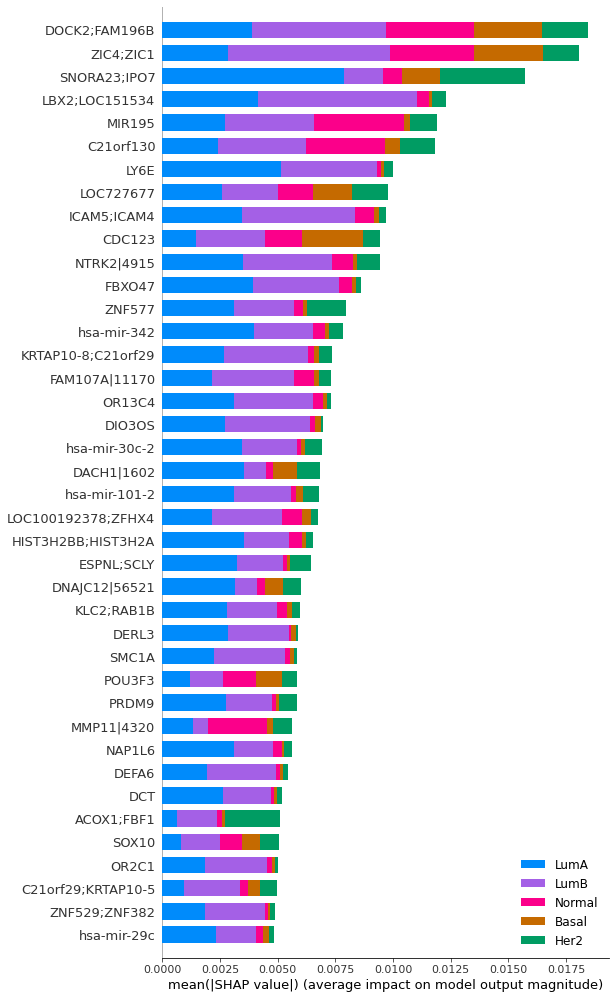

In [15]:
feature_names = [name for sublist in feat_name_list for name in sublist]
shap.summary_plot(shap_values = shap_values, feature_names=feature_names, max_display=40, plot_type='bar', class_names=list(label_dict.keys()))

In [16]:
shap_list = np.sum(np.array([np.mean(abs(each), axis=0) for each in shap_values]), axis=0)
shap_df = pd.DataFrame({"features":feature_names, "shapley_values":shap_list})
shap_df.sort_values(by="features", ascending=True).set_index("features")

,shapley_values
features,
A4GALT|53947,0.001064
AADAT,0.000881
AAGAB,0.000731
AAGAB|79719,0.000914
AATK|9625,0.001063
...,...
hsa-mir-944,0.000975
hsa-mir-95,0.000842
hsa-mir-98,0.000812


In [17]:
raw_shapley_values = np.array(shap_values)
classes = label_dict.keys()
samples = patient_id
features = feature_names
names = ['classes', 'samples', 'features']
index = pd.MultiIndex.from_product([range(s)for s in raw_shapley_values.shape], names=names)
#index.set_names(names, inplace=True)
raw_shapley_values = pd.DataFrame({'Shap_values': raw_shapley_values.flatten()}, index=index)['Shap_values']
raw_shapley_values.index = pd.MultiIndex.from_tuples([(x,y,z) for x in classes for y in samples for z in features])
time = str(datetime.datetime.now())
raw_shapley_values.to_csv("raw_shapley_values_"+time+".csv", index_label=names)